In [1]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.metrics import f1_score
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from math import log

In [2]:
X_train_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_train_glove_title.npy")
X_test_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_test_glove_title.npy")
X_valid_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_valid_glove_title.npy")
y_train_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_train_glove.npy")
y_test_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_test_glove.npy")
y_valid_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_valid_glove.npy")

In [3]:
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_train_process1),torch.LongTensor(y_train_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0, 
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_test_process1),torch.LongTensor(y_test_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0,  
    drop_last=True
)
val_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_valid_process1),torch.LongTensor(y_valid_process)),      
    batch_size=128, 
    shuffle=True,               
    num_workers=0,
    drop_last=True
)

In [4]:
def ECA(x,gamma=2,b=1):
    N,C,H,W=x.size()
    t=int(abs((log(C,2)+b)/gamma))
    k=t if t%2 else t+1
    
    avg_pool=nn.AdaptiveAvgPool2d(1).cuda()
    conv=nn.Conv1d(1,1,kernel_size=k,padding=int(k/2),bias=False).cuda()
    sigmoid=nn.Sigmoid().cuda()
    
    y=avg_pool(x)
    y=conv(y.squeeze(-1).transpose(-1,-2))
    y=y.transpose(-1,-2).unsqueeze(-1)
    y=sigmoid(y)
    return y

In [5]:
class TextRCNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,num_labels=5):
        super(TextRCNN,self).__init__()
        self.dropout = nn.Dropout(.3)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(600, 128)
        self.linear3 = nn.Linear(128, num_labels)
        self.conv1 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=6)#通过out_channel改变文中的feature map，且out_channel∈[10,50,100,200,400,600,800,1000]
        self.conv2 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=7)
        self.conv3 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=8)
        self.conv4 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=9)
        self.w_omiga = torch.randn(128,hidden_size,1,requires_grad=True).cuda()

    def forward(self, x):#x: [batch,L]
        x_embed = x.cuda()
        out = self.linear1(x_embed)
        out = out.permute(dims=[0,2,1]) #out: [batch,embedding_size + hidden_size * num_bidirectional,L]
        out_1 = self.conv1(out)
        out_1 = nn.ReLU()(out_1)
        out_1 = nn.MaxPool1d(kernel_size=495)(out_1)
        out_2 = self.conv1(out)
        out_2 = nn.ReLU()(out_2)
        out_2 = nn.MaxPool1d(kernel_size=494)(out_2)
        out_3 = self.conv1(out)
        out_3 = nn.ReLU()(out_3)
        out_3 = nn.MaxPool1d(kernel_size=493)(out_3)
        out_4 = self.conv1(out)
        out_4 = nn.ReLU()(out_4)
        out_4 = nn.MaxPool1d(kernel_size=492)(out_4)
        out_1 = out_1.unsqueeze(1).cuda()
        out_2 = out_2.unsqueeze(1).cuda()
        out_3 = out_3.unsqueeze(1).cuda()
        out_4 = out_4.unsqueeze(1).cuda()
        out = torch.cat([out_1, out_2, out_3, out_4],dim=1).cuda()
        channel_weights = F.softmax(ECA(out).squeeze().squeeze(),dim=1).unsqueeze(-1).unsqueeze(-1).expand_as(out)
        out = torch.mul(channel_weights,out)
        out = torch.sum(out, dim = 1)
        out = self.linear2(out.squeeze()) #out: [batch,num_labels]
        out = self.linear3(F.tanh(out))
        out = F.softmax(out,dim=1)
        return out

In [6]:
model = TextRCNN(5302,200,12).cuda()

In [7]:
loss_list, counter =[], []
count = 0
running_loss=0
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
total_train = 0
correct_train = 0
train_epoch, train_loss = [], []
train_acc, val_acc = [], []
avg_epoch, avg_train_loss, avg_val_acc = [], [], []
epoch_time=[]

model.train()
for epoch in range(128): 
    running_loss = 0
    total_train = 0
    correct_train = 0
    total_accuracy = 0
    total_val_accuracy = 0
    correct_val = 0
    total_val = 0   
    start1 = time.time()
    for i, data in enumerate(train_loader, 0):
        start = time.time()
        t_image, mask = data[0],torch.max(data[1],1)[1].long()
        t_image=t_image.cuda()
        optimizer.zero_grad()
        outputs = model(t_image) # forward
        ###########################################################################
        outputs=outputs.cuda()
        mask=mask.cuda()
        loss = criterion(outputs, mask.long()) # calculate the loss
        loss.backward() # back propagation
        optimizer.step() # update gradients
        running_loss += loss.item()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += mask.nelement()
        correct_train += predicted.eq(mask.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        total_accuracy += train_accuracy
        if i % 5 == 0:
            end = time.time()
            print('Epoch {}:[{}/{}], Current Loss: {}, Current Training Accuracy: {}, Time: {} ms'.format(epoch+1, i, len(train_loader), loss.item(), train_accuracy, end - start))      
            train_acc.append(train_accuracy)
            train_loss.append(loss.item())
            train_epoch.append(str(epoch+1) + '/' + str(i))

            for j, data1 in enumerate(val_loader, 0):
                t_image1, mask1 = data1[0],data1[1].long()
                outputs1 = model(t_image1)
                mask1_temp=torch.max(mask1.data,1)
                mask1_temp1=mask1_temp[1].cuda()
                _, predicted1 = torch.max(outputs1.data, 1)
                total_val += mask1.nelement()
                correct_val += predicted1.eq(mask1_temp1).sum().item()
                val_accuracy= 100 * correct_val / total_val
                total_val_accuracy += val_accuracy
            val_acc.append(val_accuracy)
    end1 = time.time()
    print('Epoch {}, train Loss: {:.3f} '.format(epoch+1, running_loss/len(train_loader)), "Avg Training Accuracy: {%d %%}" % (total_accuracy/len(train_loader)), "Avg Validation Accuracy: %d %%" % (total_val_accuracy/len(val_loader)), "Epoch Time: {} ms".format(end1 - start1))
    epoch_time.append(end1-start1)
    avg_epoch.append(epoch+1)
    avg_train_loss.append(running_loss/len(train_loader))
    avg_val_acc.append(total_val_accuracy/len(val_loader))
    #print(avg_epoch)
    #print(avg_train_loss)
    #print(avg_val_acc)

C:\Users\pc\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1:[0/16], Current Loss: 1.6181013584136963, Current Training Accuracy: 6.25, Time: 3.1193857192993164 ms
Epoch 1:[5/16], Current Loss: 1.504160761833191, Current Training Accuracy: 29.296875, Time: 0.1360001564025879 ms
Epoch 1:[10/16], Current Loss: 1.551331877708435, Current Training Accuracy: 31.960227272727273, Time: 0.1329808235168457 ms
Epoch 1:[15/16], Current Loss: 1.48762047290802, Current Training Accuracy: 34.814453125, Time: 0.1340007781982422 ms
Epoch 1, train Loss: 1.515  Avg Training Accuracy: {28 %} Avg Validation Accuracy: 27 % Epoch Time: 6.462805271148682 ms
Epoch 2:[0/16], Current Loss: 1.4152953624725342, Current Training Accuracy: 51.5625, Time: 0.1340165138244629 ms
Epoch 2:[5/16], Current Loss: 1.3799958229064941, Current Training Accuracy: 55.208333333333336, Time: 0.13301324844360352 ms
Epoch 2:[10/16], Current Loss: 1.3250573873519897, Current Training Accuracy: 56.10795454545455, Time: 0.13402533531188965 ms
Epoch 2:[15/16], Current Loss: 1.31134998798

Epoch 14:[15/16], Current Loss: 0.991074800491333, Current Training Accuracy: 88.8671875, Time: 0.13399744033813477 ms
Epoch 14, train Loss: 1.014  Avg Training Accuracy: {89 %} Avg Validation Accuracy: 60 % Epoch Time: 3.462214946746826 ms
Epoch 15:[0/16], Current Loss: 1.0788878202438354, Current Training Accuracy: 80.46875, Time: 0.13502097129821777 ms
Epoch 15:[5/16], Current Loss: 1.0028660297393799, Current Training Accuracy: 90.10416666666667, Time: 0.136016845703125 ms
Epoch 15:[10/16], Current Loss: 0.9811022281646729, Current Training Accuracy: 92.40056818181819, Time: 0.13399958610534668 ms
Epoch 15:[15/16], Current Loss: 1.0181856155395508, Current Training Accuracy: 92.578125, Time: 0.13500046730041504 ms
Epoch 15, train Loss: 0.994  Avg Training Accuracy: {90 %} Avg Validation Accuracy: 61 % Epoch Time: 3.4621222019195557 ms
Epoch 16:[0/16], Current Loss: 0.9734108448028564, Current Training Accuracy: 96.875, Time: 0.13509798049926758 ms
Epoch 16:[5/16], Current Loss: 0.9

Epoch 28:[5/16], Current Loss: 0.9354323148727417, Current Training Accuracy: 97.91666666666667, Time: 0.12833952903747559 ms
Epoch 28:[10/16], Current Loss: 0.9283820390701294, Current Training Accuracy: 98.08238636363636, Time: 0.14384126663208008 ms
Epoch 28:[15/16], Current Loss: 0.9514442682266235, Current Training Accuracy: 97.900390625, Time: 0.12314844131469727 ms
Epoch 28, train Loss: 0.926  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 63 % Epoch Time: 3.433307647705078 ms
Epoch 29:[0/16], Current Loss: 0.942837119102478, Current Training Accuracy: 96.09375, Time: 0.14181137084960938 ms
Epoch 29:[5/16], Current Loss: 0.9128354787826538, Current Training Accuracy: 97.78645833333333, Time: 0.12585854530334473 ms
Epoch 29:[10/16], Current Loss: 0.9133485555648804, Current Training Accuracy: 97.79829545454545, Time: 0.1412672996520996 ms
Epoch 29:[15/16], Current Loss: 0.9206183552742004, Current Training Accuracy: 97.900390625, Time: 0.1257774829864502 ms
Epoch 29, trai

Epoch 41, train Loss: 0.924  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 65 % Epoch Time: 3.4803390502929688 ms
Epoch 42:[0/16], Current Loss: 0.9286112189292908, Current Training Accuracy: 97.65625, Time: 0.12876009941101074 ms
Epoch 42:[5/16], Current Loss: 0.9054827690124512, Current Training Accuracy: 98.17708333333333, Time: 0.13304376602172852 ms
Epoch 42:[10/16], Current Loss: 0.9208754301071167, Current Training Accuracy: 98.22443181818181, Time: 0.12556171417236328 ms
Epoch 42:[15/16], Current Loss: 0.9208839535713196, Current Training Accuracy: 98.14453125, Time: 0.12582707405090332 ms
Epoch 42, train Loss: 0.923  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 66 % Epoch Time: 3.471198320388794 ms
Epoch 43:[0/16], Current Loss: 0.9364522695541382, Current Training Accuracy: 96.875, Time: 0.13310933113098145 ms
Epoch 43:[5/16], Current Loss: 0.920870304107666, Current Training Accuracy: 98.4375, Time: 0.12520146369934082 ms
Epoch 43:[10/16], Current Loss: 0.

Epoch 55:[10/16], Current Loss: 0.9128310680389404, Current Training Accuracy: 98.50852272727273, Time: 0.1414341926574707 ms
Epoch 55:[15/16], Current Loss: 0.9128332138061523, Current Training Accuracy: 98.291015625, Time: 0.12753963470458984 ms
Epoch 55, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 65 % Epoch Time: 3.4747724533081055 ms
Epoch 56:[0/16], Current Loss: 0.9129005670547485, Current Training Accuracy: 99.21875, Time: 0.14242100715637207 ms
Epoch 56:[5/16], Current Loss: 0.9356951117515564, Current Training Accuracy: 98.69791666666667, Time: 0.1353757381439209 ms
Epoch 56:[10/16], Current Loss: 0.9204618334770203, Current Training Accuracy: 98.29545454545455, Time: 0.13531947135925293 ms
Epoch 56:[15/16], Current Loss: 0.9128905534744263, Current Training Accuracy: 98.291015625, Time: 0.13940739631652832 ms
Epoch 56, train Loss: 0.922  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 65 % Epoch Time: 3.502148389816284 ms
Epoch 57:[0/16],

Epoch 69:[5/16], Current Loss: 0.9362172484397888, Current Training Accuracy: 98.30729166666667, Time: 0.12700295448303223 ms
Epoch 69:[10/16], Current Loss: 0.9440050721168518, Current Training Accuracy: 98.1534090909091, Time: 0.12885475158691406 ms
Epoch 69:[15/16], Current Loss: 0.9194358587265015, Current Training Accuracy: 98.14453125, Time: 0.12754559516906738 ms
Epoch 69, train Loss: 0.923  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.5064566135406494 ms
Epoch 70:[0/16], Current Loss: 0.9256561398506165, Current Training Accuracy: 97.65625, Time: 0.12086009979248047 ms
Epoch 70:[5/16], Current Loss: 0.9284786581993103, Current Training Accuracy: 98.17708333333333, Time: 0.1436786651611328 ms
Epoch 70:[10/16], Current Loss: 0.9207574725151062, Current Training Accuracy: 98.1534090909091, Time: 0.1253361701965332 ms
Epoch 70:[15/16], Current Loss: 0.9206691980361938, Current Training Accuracy: 98.193359375, Time: 0.13875412940979004 ms
Epoch 70, train

Epoch 82, train Loss: 0.919  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.626323938369751 ms
Epoch 83:[0/16], Current Loss: 0.9200165271759033, Current Training Accuracy: 98.4375, Time: 0.13399934768676758 ms
Epoch 83:[5/16], Current Loss: 0.9123028516769409, Current Training Accuracy: 98.69791666666667, Time: 0.13599824905395508 ms
Epoch 83:[10/16], Current Loss: 0.9283625483512878, Current Training Accuracy: 98.57954545454545, Time: 0.13699913024902344 ms
Epoch 83:[15/16], Current Loss: 0.9127533435821533, Current Training Accuracy: 98.6328125, Time: 0.13499903678894043 ms
Epoch 83, train Loss: 0.918  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.481004238128662 ms
Epoch 84:[0/16], Current Loss: 0.9282495975494385, Current Training Accuracy: 97.65625, Time: 0.13399910926818848 ms
Epoch 84:[5/16], Current Loss: 0.91234290599823, Current Training Accuracy: 98.95833333333333, Time: 0.13300061225891113 ms
Epoch 84:[10/16], Current 

Epoch 96:[10/16], Current Loss: 0.9205309748649597, Current Training Accuracy: 98.79261363636364, Time: 0.13610029220581055 ms
Epoch 96:[15/16], Current Loss: 0.928345799446106, Current Training Accuracy: 98.681640625, Time: 0.13700127601623535 ms
Epoch 96, train Loss: 0.918  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.480001449584961 ms
Epoch 97:[0/16], Current Loss: 0.9198579788208008, Current Training Accuracy: 98.4375, Time: 0.1411113739013672 ms
Epoch 97:[5/16], Current Loss: 0.9205238819122314, Current Training Accuracy: 98.4375, Time: 0.14104056358337402 ms
Epoch 97:[10/16], Current Loss: 0.9205224514007568, Current Training Accuracy: 98.65056818181819, Time: 0.1351029872894287 ms
Epoch 97:[15/16], Current Loss: 0.9127151966094971, Current Training Accuracy: 98.6328125, Time: 0.13610148429870605 ms
Epoch 97, train Loss: 0.918  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.5090062618255615 ms
Epoch 98:[0/16], Current Loss:

Epoch 110:[5/16], Current Loss: 0.9119873642921448, Current Training Accuracy: 98.95833333333333, Time: 0.1340024471282959 ms
Epoch 110:[10/16], Current Loss: 0.9127047657966614, Current Training Accuracy: 98.50852272727273, Time: 0.14100074768066406 ms
Epoch 110:[15/16], Current Loss: 0.9127016663551331, Current Training Accuracy: 98.6328125, Time: 0.13810229301452637 ms
Epoch 110, train Loss: 0.918  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.5000195503234863 ms
Epoch 111:[0/16], Current Loss: 0.9127048254013062, Current Training Accuracy: 99.21875, Time: 0.14013147354125977 ms
Epoch 111:[5/16], Current Loss: 0.9205105900764465, Current Training Accuracy: 98.69791666666667, Time: 0.13701677322387695 ms
Epoch 111:[10/16], Current Loss: 0.9283273816108704, Current Training Accuracy: 98.50852272727273, Time: 0.1371016502380371 ms
Epoch 111:[15/16], Current Loss: 0.9205119609832764, Current Training Accuracy: 98.6328125, Time: 0.13610148429870605 ms
Epoch 11

Epoch 123:[15/16], Current Loss: 0.9048796892166138, Current Training Accuracy: 98.6328125, Time: 0.14201760292053223 ms
Epoch 123, train Loss: 0.918  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.517369508743286 ms
Epoch 124:[0/16], Current Loss: 0.9126946330070496, Current Training Accuracy: 99.21875, Time: 0.14174365997314453 ms
Epoch 124:[5/16], Current Loss: 0.9120867848396301, Current Training Accuracy: 99.47916666666667, Time: 0.12581896781921387 ms
Epoch 124:[10/16], Current Loss: 0.9355605840682983, Current Training Accuracy: 99.07670454545455, Time: 0.14087700843811035 ms
Epoch 124:[15/16], Current Loss: 0.9355555176734924, Current Training Accuracy: 98.6328125, Time: 0.1441330909729004 ms
Epoch 124, train Loss: 0.918  Avg Training Accuracy: {99 %} Avg Validation Accuracy: 68 % Epoch Time: 3.4979631900787354 ms
Epoch 125:[0/16], Current Loss: 0.919991672039032, Current Training Accuracy: 98.4375, Time: 0.14243531227111816 ms
Epoch 125:[5/16], Curre

In [13]:
model.eval()
pred_correct_num=[]
pred_total_num=[]
pred_result_list=[]
pred_prob_list = []
label_prob_list=[]
label_list=[]
for i, data in enumerate(test_loader, 0):
    t_image, mask = data[0],torch.max(data[1],1)[1].long()
    mask=mask.cuda()
    output_test=model(t_image)
    pred_prob_list.append(output_test)
    label_prob_list.append(data[1])
    label_list.append(mask)
    output=torch.max(output_test,1)[1].long()
    pred_result_list.append(output)
    pred_correct_num.append(output.eq(mask).sum().item())
    pred_total_num.append(output_test.shape[0])
acc_test=sum(pred_correct_num)/sum(pred_total_num)
print("The accuracy of detecting news bias: {}".format(('%.4f%%'%(acc_test*100))))

The accuracy of detecting news bias: 81.5104%


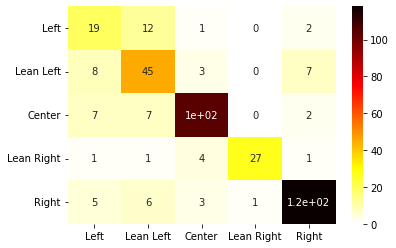

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
for i in range(len(pred_result_list)):
    if len(pred_result_list) == 1:
        pred_result = pred_result_list[0]
        label = label_list[0]
    if len(pred_result_list) == 2:
        pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
        label = torch.cat((label_list[0], label_list[1]), -1)
    if len(pred_result_list) > 2:
        pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
        label = torch.cat((label_list[0], label_list[1]), -1)
    for j in range(len(pred_result_list)-2):
        pred_result = torch.cat((pred_result, pred_result_list[j+2]), -1)
        label = torch.cat((label, label_list[j+2]), -1)
label = label.cpu()
pred_result = pred_result.cpu()
C=confusion_matrix(label,pred_result)
df=pd.DataFrame(C,index=["Left","Lean Left","Center","Lean Right","Right"],columns=["Left","Lean Left","Center","Lean Right","Right"])
p1=sns.heatmap(df,annot=True,cmap="hot_r")
s1 = p1.get_figure()

In [15]:
for i in range(len(pred_prob_list)):
    if len(pred_prob_list) == 1:
        pred_prob = pred_prob_list[0]
        label_prob = label_prob_list[0]
    if len(pred_prob_list) == 2:
        pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
        label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    if len(pred_prob_list) > 2:
        pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
        label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    for j in range(len(pred_prob_list)-2):
        pred_prob = torch.cat((pred_prob, pred_prob_list[j+2]), -1)
        label_prob = torch.cat((label_prob, label_prob_list[j+2]), -1)
label_prob = label_prob.cpu()
pred_prob = pred_prob.cpu()
criterion=nn.L1Loss(reduction="mean")
loss=criterion(pred_prob, label_prob)
print("MAE Value: {}".format("%.4f" % loss))

MAE Value: 0.0746


In [16]:
from sklearn.metrics import f1_score
f1_score = f1_score(pred_result,label,average="macro")
print("Macro-F1 Score: {}".format("%.4f" % f1_score))

Macro-F1 Score: 0.7677
